# **Exercise 1: CNN**

**Group 2406**: 
- Cavezza Lorenzo - 2130648
- Doda Giulia - 2104267
- Longaroni Giacomo - 2126898
- Ravagnani Laura - 2104271

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
import tensorflow.random as tf_r

from scipy import stats

import seaborn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

## Useful functions

In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()


def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10

    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]

    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()

def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Read data

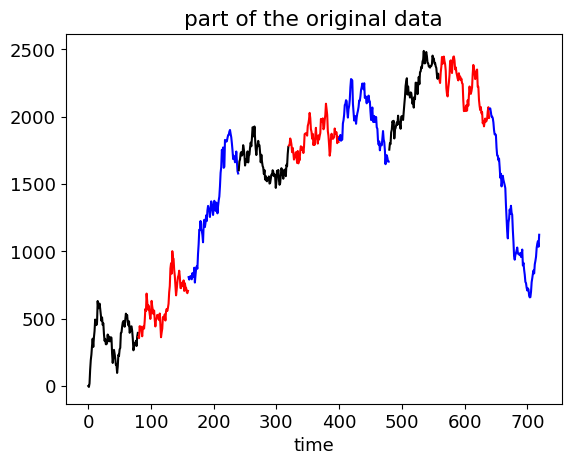

data:  4000


In [3]:
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

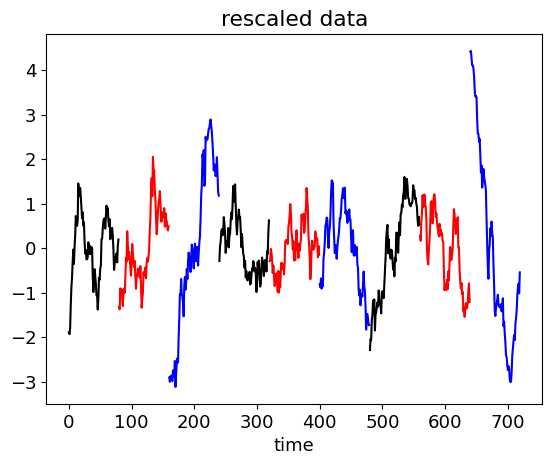

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [4]:
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

# rescale (crude version, variance should be used)
x = x / x.std()

Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [5]:
def build_model(NCONV=1, NF=5, KS=6, NF2=5, KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=5,
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu',
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2, activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF,
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu',
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())

    # Last layer, with n_class units
    initializer=tf.keras.initializers.RandomNormal(mean=0.,stddev=0.5)
    model.add(Dense(n_class, activation='softmax',kernel_initializer=initializer)) # softmax !

    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.Adam()

    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

In [6]:
# reproducibility
np.random.seed(12345)
tf_r.set_seed(12345)

In [7]:
NCONV=1

model=build_model(NCONV=NCONV, KS=11)

print('----- Model',NCONV,'-----')
print(model.summary())
print(model.layers)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-03-09 16:38:18.631029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-09 16:38:18.632469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 5)             60        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 5)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 5)             105       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                    

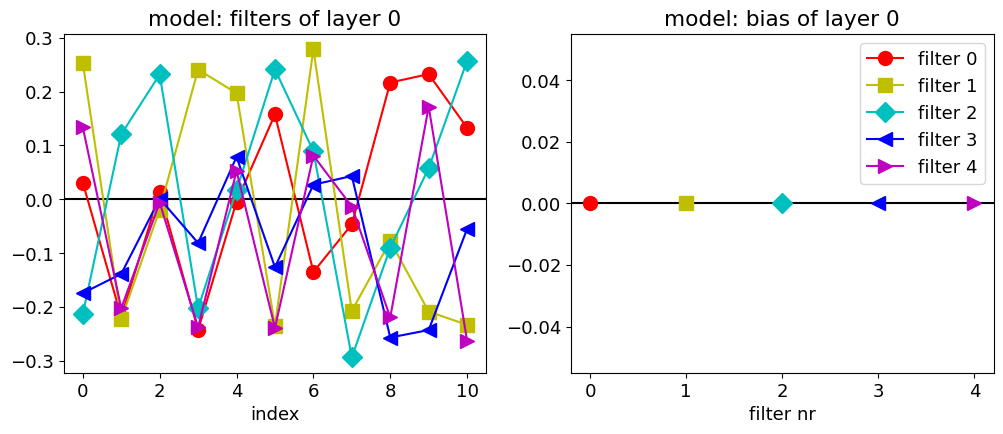

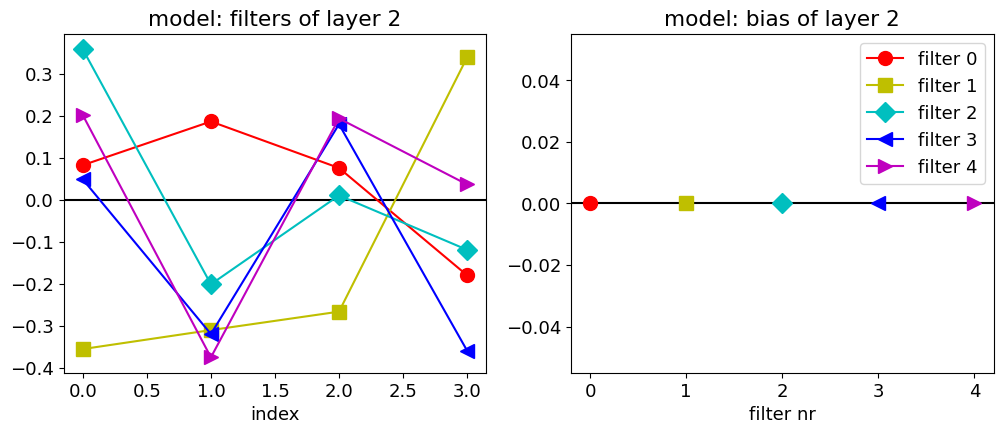

In [8]:
Show_weights(model,0)
Show_weights(model,2)

In [ ]:
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)
print("end of fit")

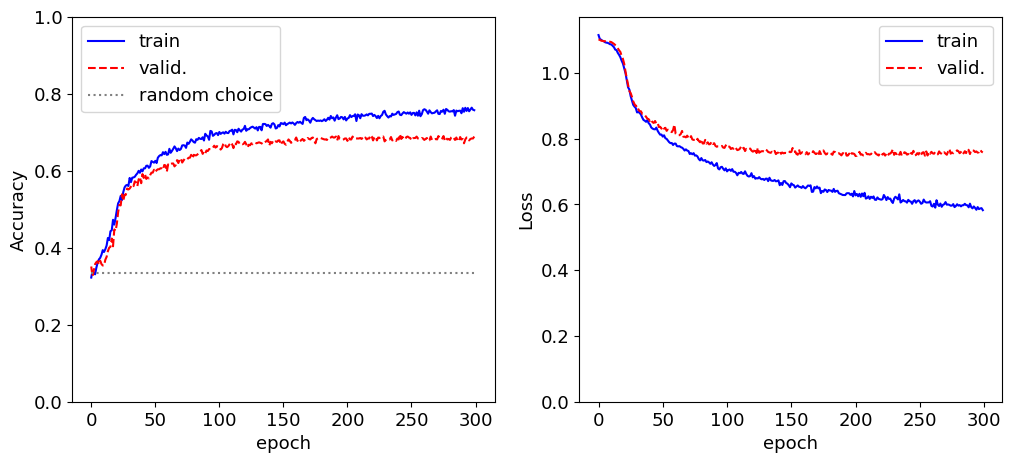

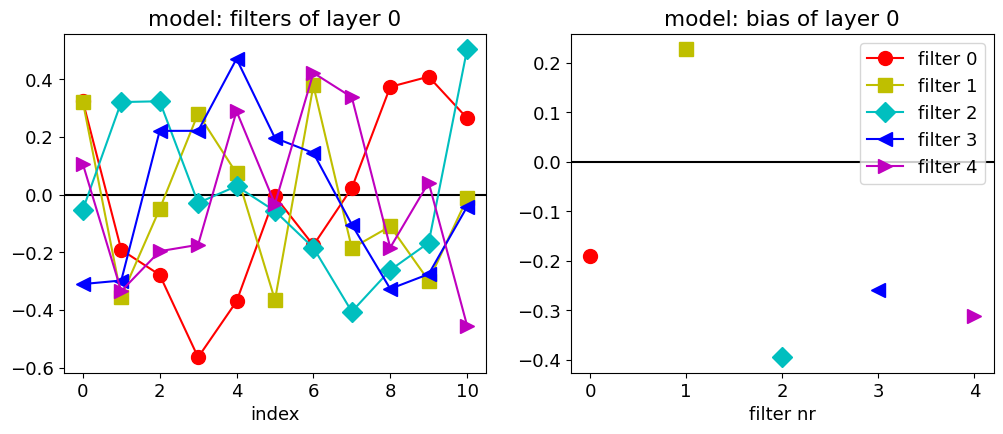

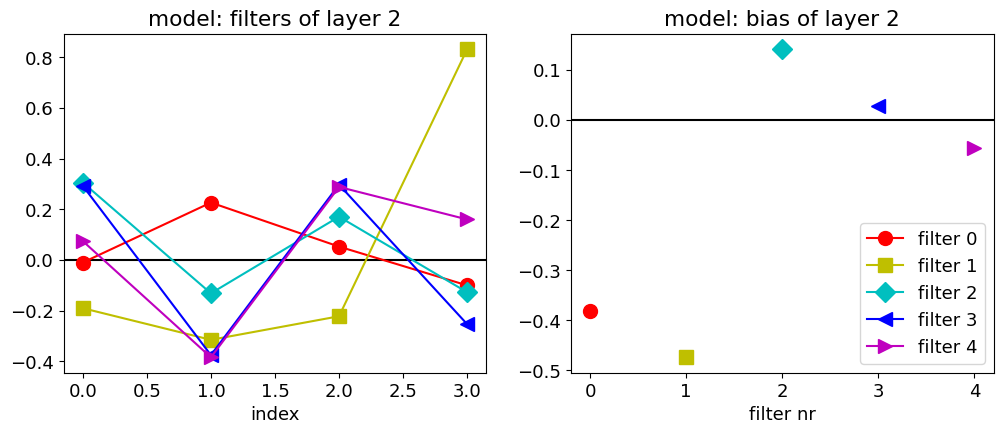

In [10]:
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

2024-03-09 16:40:46.862169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 0s 3ms/step


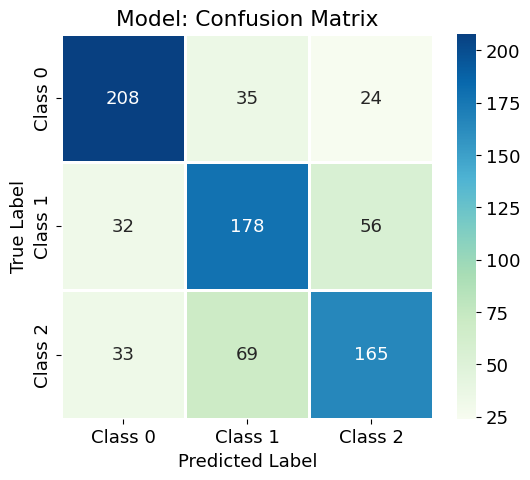

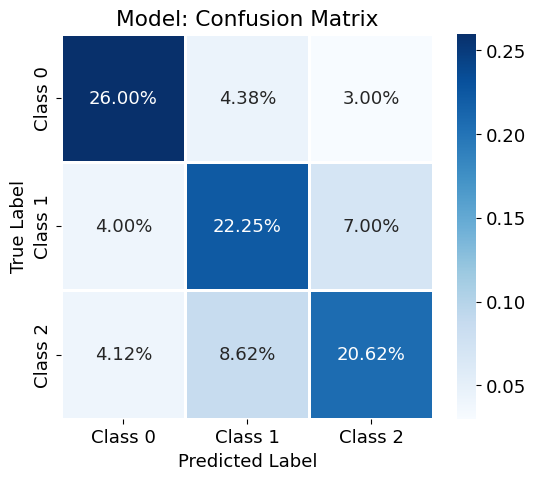

In [11]:
LABELS = ["Class 0","Class 1","Class 2"]

y_pred_val = np.array(model.predict(x_val))
# take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

In [ ]:
# model with regularization

model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.legacy.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True)

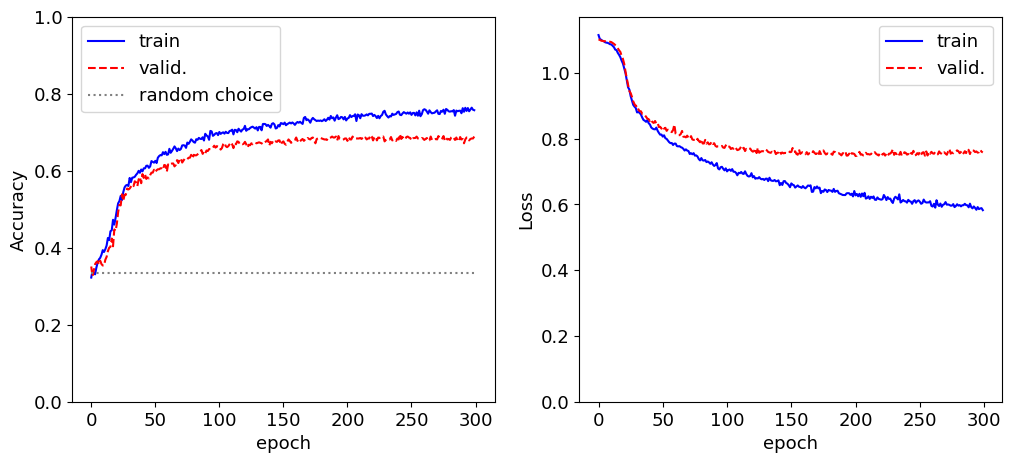

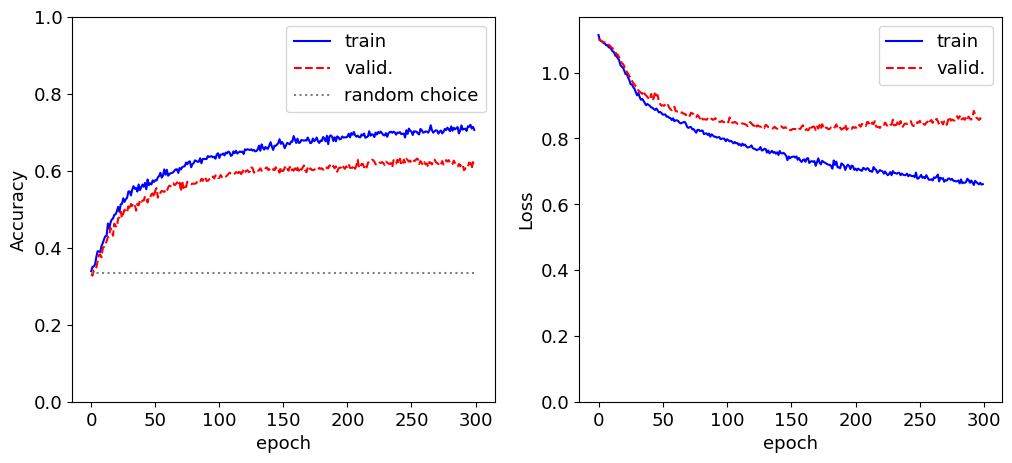

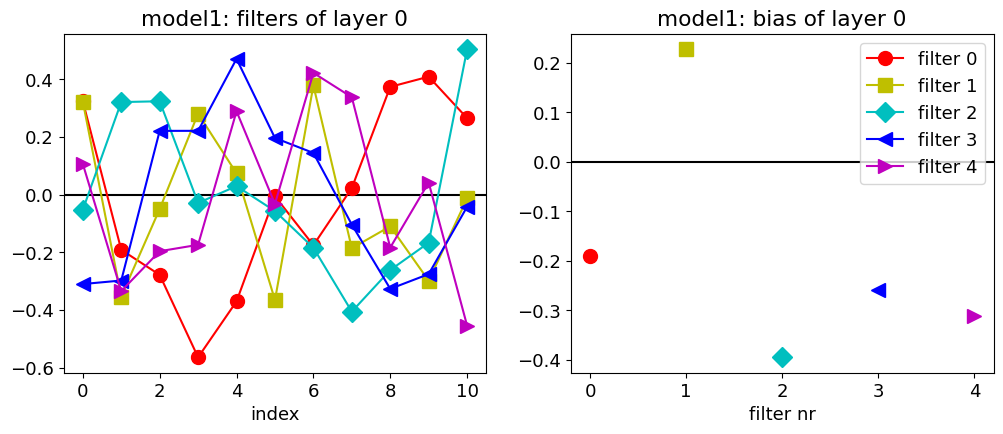

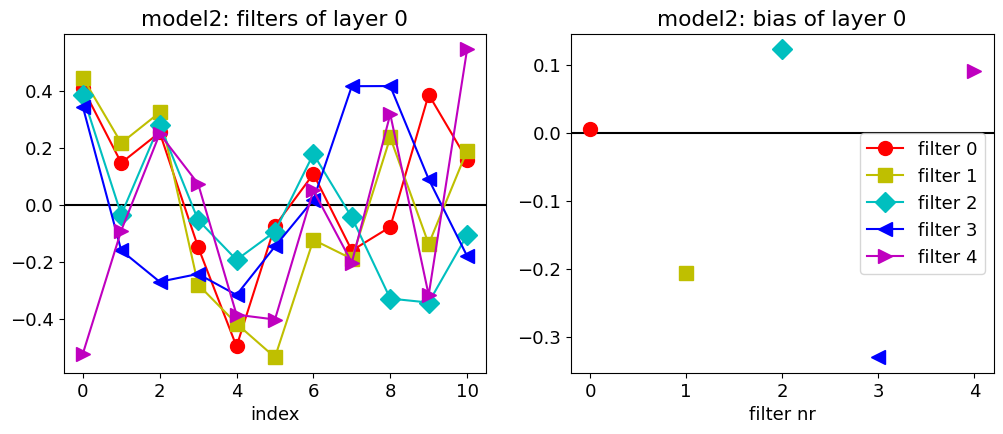

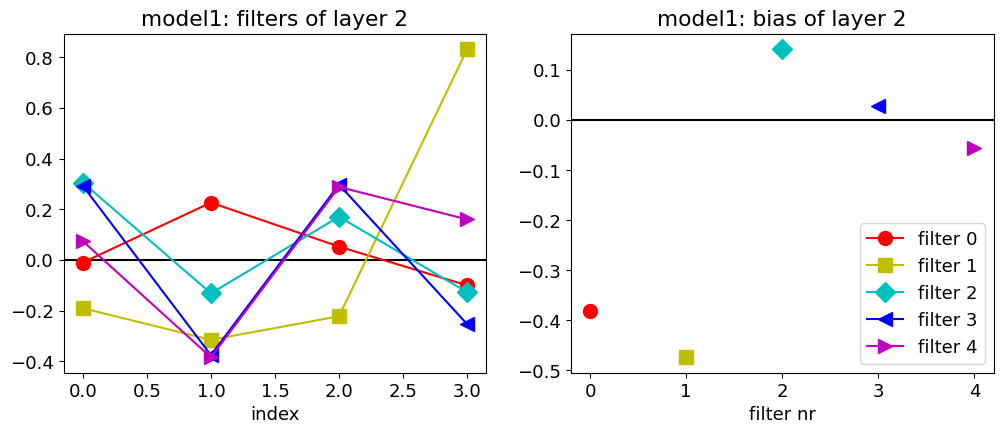

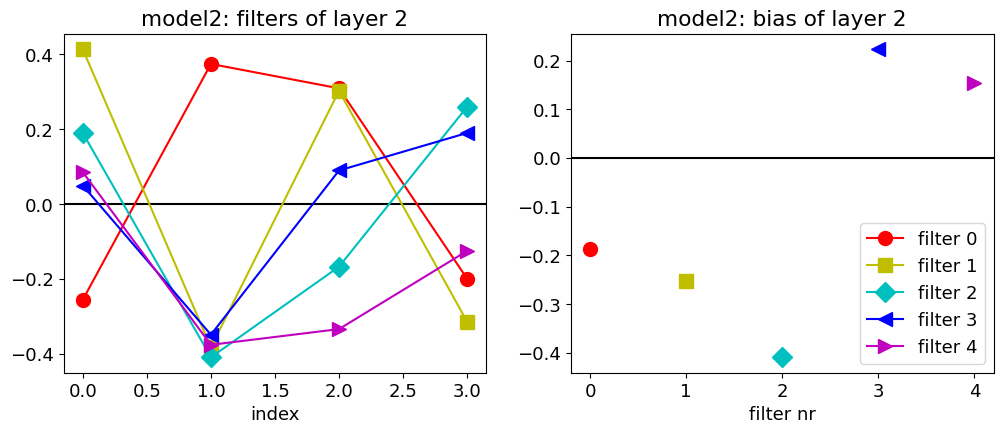

 7/25 [=======>......................] - ETA: 0s

2024-03-09 16:43:03.481050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 0s 5ms/step


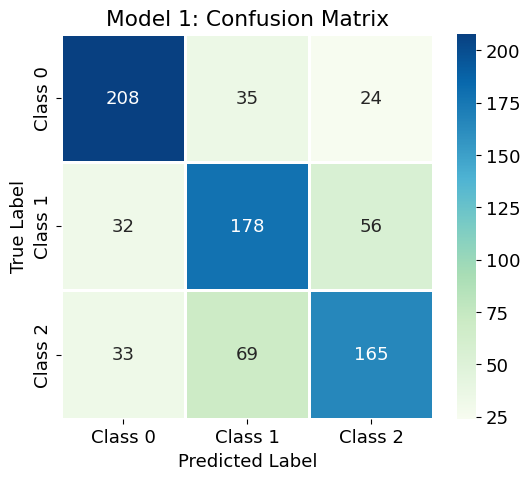

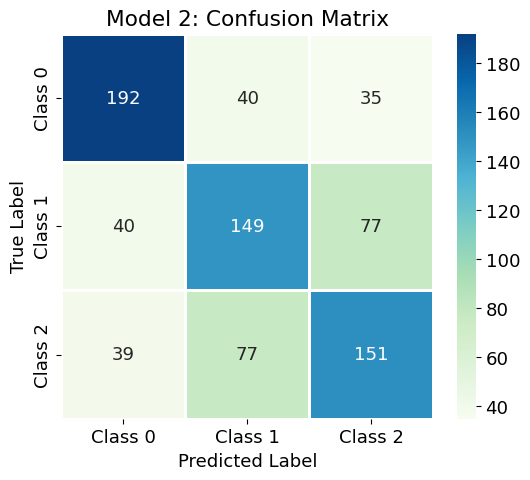

In [13]:
Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")

y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

## 1. Using Global max pooling

Now we implement a model ending with a global max pooling layer.

In [15]:
NCONV2 = 2
model2 = build_model(NCONV=NCONV2,KS=11)

print('----- Model',NCONV2,'-----')
print(model2.summary())
print(model2.layers)

----- Model 2 -----
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 70, 5)             60        
                                                                 
 conv1d_6 (Conv1D)           (None, 67, 5)             105       
                                                                 
 conv1d_7 (Conv1D)           (None, 64, 5)             105       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
 flatten_2 (Flatten)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 18        
                                  

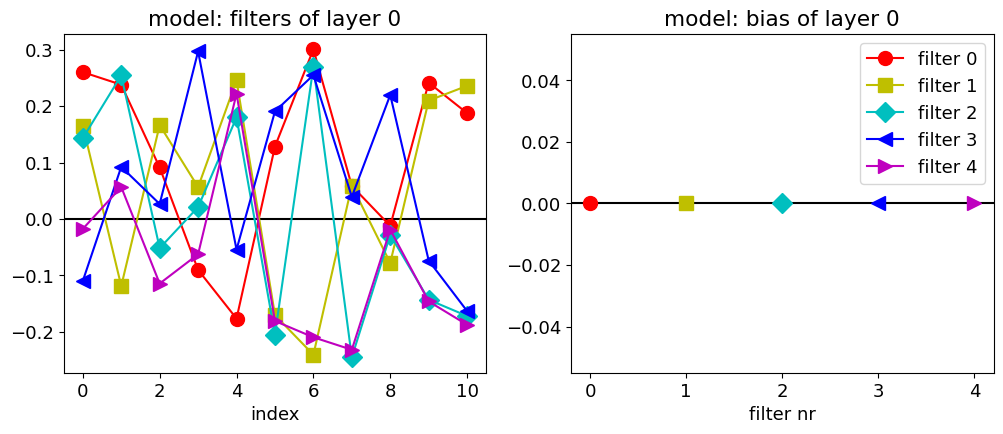

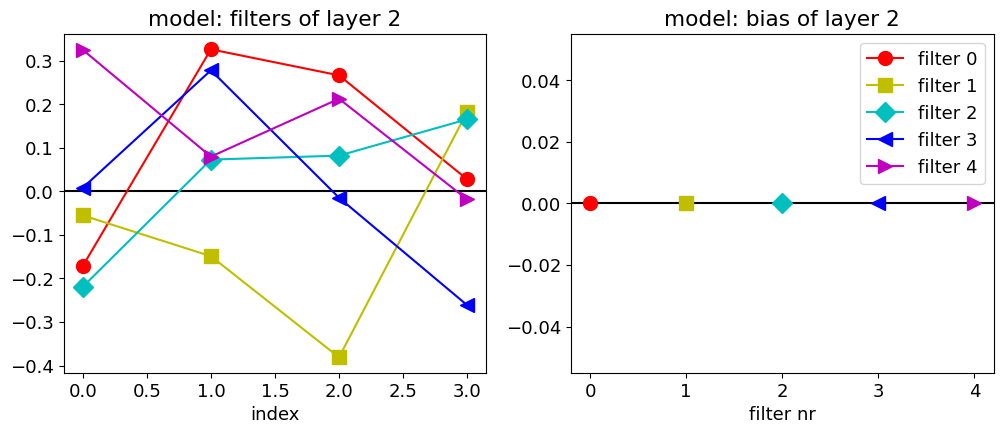

In [16]:
Show_weights(model2,0)
Show_weights(model2,2)

In [ ]:
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)
print("end of fit")

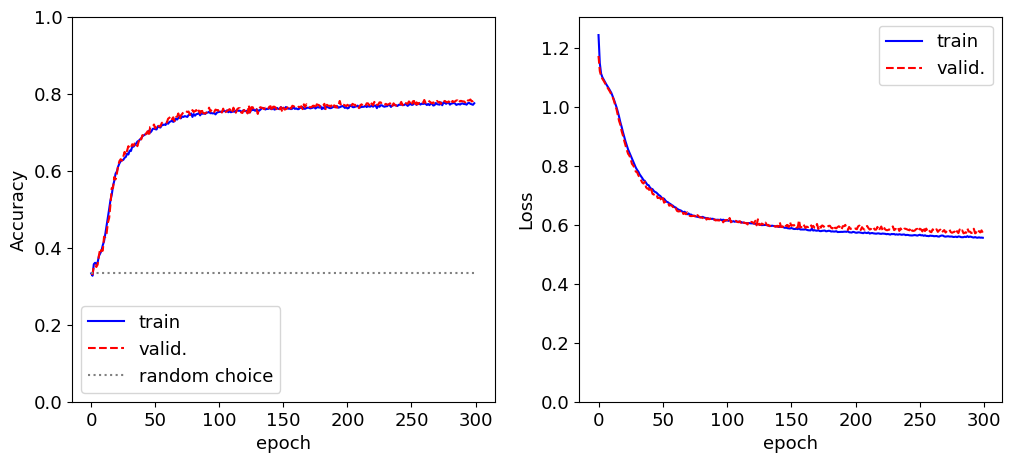

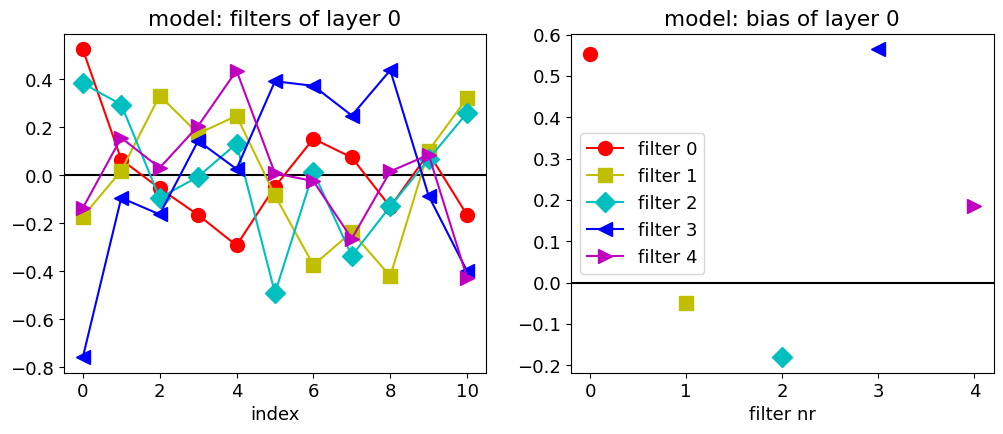

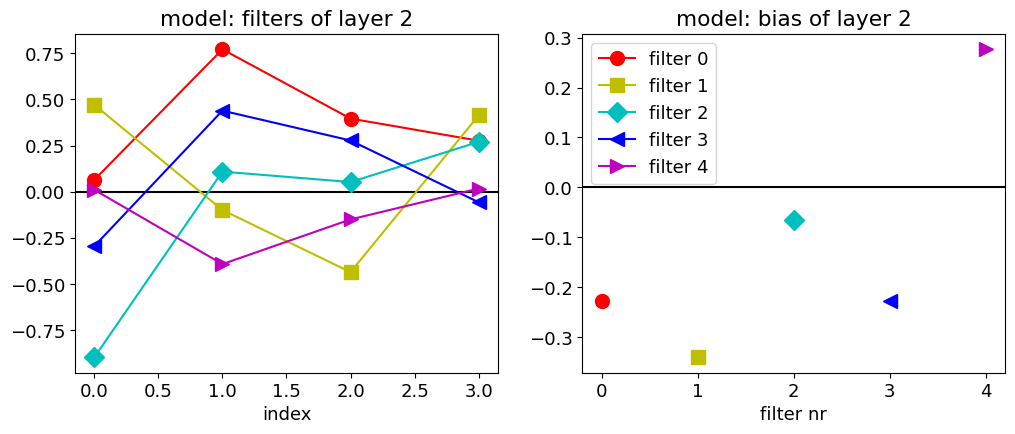

In [18]:
Show_history(fit2)
Show_weights(model2,0)
Show_weights(model2,2)

25/25 [==============================] - 0s 3ms/step


2024-03-09 16:47:28.518026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


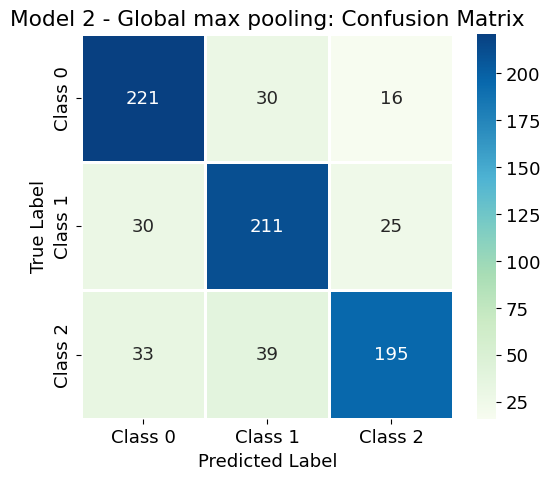

In [19]:
y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2 - Global max pooling")

For the rest of the study, we adopt the model with a global max pooling layer because it performs better in terms of validation accuracy and it manages to avoid overfit with respect to the others. 

## 2. Different optimizers

Now we perform a grid search in order to select the best optimizer among Adam, Adagrad, RMSprop, Nesterov and Lion. Moreover, for each optimizer, we search for the best learning rate.

In [ ]:
optimname = ['Adam', 'Adagrad', 'RMSprop', 'Nesterov', 'Lion']   # different optimizers
eta = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 1e-1, 0.2, 0.5, 1]
optim = [ [keras.optimizers.Adam(learning_rate=e) for e in eta],
         [keras.optimizers.Adagrad(learning_rate=e) for e in eta],
         [keras.optimizers.RMSprop(learning_rate=e) for e in eta],
         [keras.optimizers.SGD(learning_rate=e, nesterov=True) for e in eta],
         [keras.optimizers.Lion(learning_rate=e) for e in eta] ]

mindeltas = 0.01
accuracy = []
EPOCHS2 = 500
for i, o in enumerate(optim):
  model_acc=[]
  print(optimname[i])
  for j, lr in enumerate(o):
    model = build_model(NCONV=2,KS=11)
    callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=mindeltas)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=lr, metrics=['accuracy'])
    fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE2, epochs=EPOCHS2, callbacks=[callback], validation_data=(x_val, y_val), verbose=1, shuffle=True)
    model_acc.append(fit.history['val_accuracy'][-1])
  accuracy.append(model_acc)

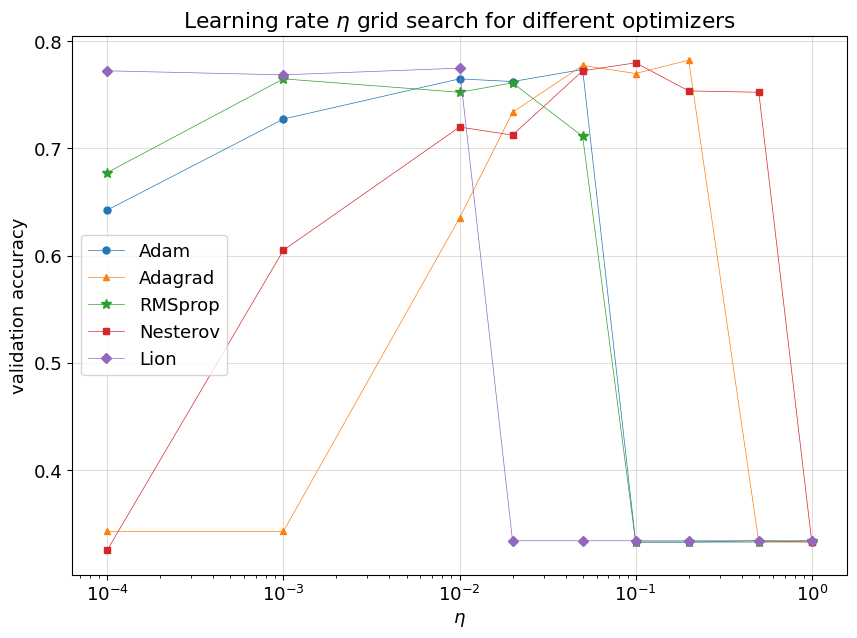

In [20]:
# validation accuracy plot for learning rate optimizer grid search

fig, ax = plt.subplots(figsize=(10,7))
ax.grid(alpha=0.4)
ax.plot(eta,accuracy[0],label='Adam', linewidth=0.5,  markersize=5, marker = 'o')
ax.plot(eta,accuracy[1],label='Adagrad', linewidth=0.5,  markersize=5, marker = '^')
ax.plot(eta,accuracy[2],label='RMSprop', linewidth=0.5,  markersize=7, marker = '*')
ax.plot(eta,accuracy[3],label='Nesterov', linewidth=0.5,  markersize=5, marker = 's')
ax.plot(eta,accuracy[4],label='Lion', linewidth=0.5,  markersize=5, marker = 'D')

ax.legend()
ax.set_xlabel('$\eta$')
ax.set_ylabel('validation accuracy')
ax.set_title('Learning rate $\eta$ grid search for different optimizers')
plt.xscale('log')
plt.show()

A first search over the learning rate has been performed for the various optimizers without averaging over several random initializations. As we can see each optimizers has a peak in the validation accuracy for a certain learning rate value. Also for each model the maximum accuracy is reached around 78%, so it is impossible with only this first analysis to define the optimal model.

We now proceed fitting every model with its own best learning rate averaging over several initializations, so as to finally choose the best optimizer in a statistically relevant way.

In [21]:
# best learning rates
best_lr_adam = eta[np.argmax(accuracy[0])]
best_lr_adagrad = eta[np.argmax(accuracy[1])]
best_lr_RMSprop = eta[np.argmax(accuracy[2])]
best_lr_nesterov = eta[np.argmax(accuracy[3])]
best_lr_lion = eta[np.argmax(accuracy[4])]

In [22]:
# early stopping conditions
mindelta = 0.001
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=mindelta)
callbacks = callback

# number of run for every model
N_run = 20

#### Adam

In [23]:
def define_adam(NF=5,KS=6, NF2=5,KS2=4, lamb=0):

    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF,
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=best_lr_adam)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
# store accuracy for every fit
adam_val_acc = []

for i in range(N_run):

    print(f'----- {i} -----\n')

    model_adam = define_adam(KS=11)
    fit_adam = model_adam.fit(x_train,
                              y_train,
                              batch_size=BATCH_SIZE2,
                              epochs=500,
                              callbacks=[callback],
                              validation_data=(x_val, y_val),
                              verbose=1,
                              shuffle=True)

    adam_val_acc.append(fit_adam.history['val_accuracy'][-1])

In [25]:
# calculate mean validation accuracy and correspondent error
adam_val_mean = np.mean(adam_val_acc)
adam_val_err = np.std(adam_val_acc)/np.sqrt(N_run)

print(f'mean: {adam_val_mean:.4f}')
print(f'error: {adam_val_err:.4f}')

mean: 0.6951
error: 0.0348


#### Adagrad

In [26]:
def define_adagrad(NF=5,KS=6, NF2=5,KS2=4, lamb=0):

    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF,
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Adagrad(learning_rate=best_lr_adagrad)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
# store validation accuracy
adagrad_val_acc = []

for i in range(N_run):

    print(f'----- {i} -----\n')

    model_adagrad = define_adagrad(KS=11)

    fit_adagrad = model_adagrad.fit(x_train,
                                    y_train,
                                    batch_size=BATCH_SIZE2,
                                    epochs=500,
                                    callbacks=[callback],
                                    validation_data=(x_val, y_val),
                                    verbose=1,
                                    shuffle=True)

    adagrad_val_acc.append(fit_adagrad.history['val_accuracy'][-1])

In [28]:
adagrad_val_mean = np.mean(adagrad_val_acc)
adagrad_val_err = np.std(adagrad_val_acc)/np.sqrt(N_run)

print(f'mean: {adagrad_val_mean:.4f}')
print(f'error: {adagrad_val_err:.4f}')

mean: 0.7705
error: 0.0024


#### RMSprop

In [29]:
def define_rms(NF=5,KS=6, NF2=5,KS2=4, lamb=0):

    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF,
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.RMSprop(learning_rate=best_lr_RMSprop)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
# store validation accuracy at every fit
rms_val_acc = []

for i in range(N_run):

    print(f'----- {i} -----\n')

    model_rms = define_rms(KS=11)

    fit_rms = model_rms.fit(x_train,
                            y_train,
                            batch_size=BATCH_SIZE2,
                            epochs=500,
                            callbacks=[callback],
                            validation_data=(x_val, y_val),
                            verbose=1,
                            shuffle=True)

    rms_val_acc.append(fit_rms.history['val_accuracy'][-1])

In [31]:
rms_val_mean = np.mean(rms_val_acc)
rms_val_err = np.std(rms_val_acc)/np.sqrt(N_run)

print(f'mean: {rms_val_mean:.4f}')
print(f'std: {rms_val_err:.4f}')

mean: 0.7690
std: 0.0026


#### Nesterov

In [32]:
def define_nest(NF=5,KS=6, NF2=5,KS2=4, lamb=0):

    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF,
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.SGD(learning_rate=best_lr_nesterov, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
# store validation accuracy at every fit
nest_val_acc = []

for i in range(N_run):

    print(f'----- {i} -----\n')

    model_nest = define_nest(KS=11)

    fit_nest = model_nest.fit(x_train,
                              y_train,
                              batch_size=BATCH_SIZE2,
                              epochs=500,
                              callbacks=[callback],
                              validation_data=(x_val, y_val),
                              verbose=1,
                              shuffle=True)

    nest_val_acc.append(fit_nest.history['val_accuracy'][-1])

In [34]:
nest_val_mean = np.mean(nest_val_acc)
nest_val_err = np.std(nest_val_acc)/np.sqrt(N_run)

print(f'mean: {nest_val_mean:.4f}')
print(f'std: {nest_val_err:.4f}')

mean: 0.7687
std: 0.0027


#### Lion

In [35]:
def define_lion(NF=5,KS=6, NF2=5,KS2=4, lamb=0):

    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF,
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Lion(learning_rate=best_lr_lion)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [ ]:
# store validation accuracy at every fit
lion_val_acc = []

for i in range(N_run):

    print(f'----- {i} -----\n')

    model_lion = define_lion(KS=11)

    fit_lion = model_lion.fit(x_train,
                              y_train,
                              batch_size=BATCH_SIZE2,
                              epochs=500,
                              callbacks=[callback],
                              validation_data=(x_val, y_val),
                              verbose=1,
                              shuffle=True)

    lion_val_acc.append(fit_lion.history['val_accuracy'][-1])

In [37]:
lion_val_mean = np.mean(lion_val_acc)
lion_val_err = np.std(lion_val_acc)/np.sqrt(N_run)

print(f'mean: {lion_val_mean:.4f}')
print(f'std: {lion_val_err:.4f}')

mean: 0.7443
std: 0.0195


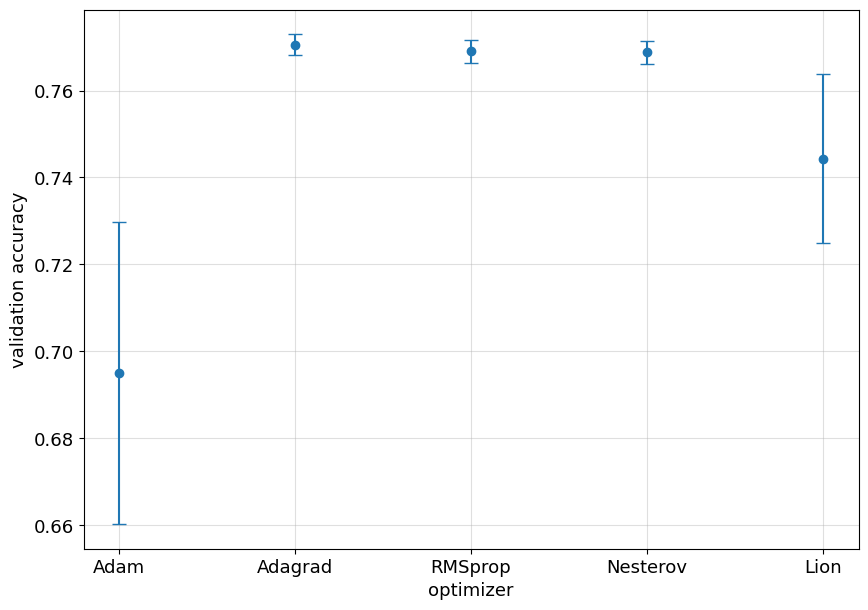

In [38]:
# plot to display the best optimizer
means = [adam_val_mean, adagrad_val_mean, rms_val_mean, nest_val_mean, lion_val_mean]
stds = [adam_val_err, adagrad_val_err, rms_val_err, nest_val_err, lion_val_err]

fig, ax = plt.subplots(figsize = (10, 7))
ax.grid(alpha=0.4)
ax.errorbar(optimname, means, stds, fmt='o', capsize=5, capthick=1)
ax.set_ylabel('validation accuracy')
ax.set_xlabel('optimizer')
plt.show()

The results suggest similar validation accuracies for Adagrad, RMSprop and Nesterov. The best one seems to be Adagrad but the other two are too close and well beyond the error bounds to be completely discarded. In practice we proceed selecting Adagrad as our default optimizer method.

## 3. Regularization

The next step involves doing another gridsearch over the regularization, Kernel size and number of filters in our CNN. We choose to only use the L2 type of regularization as other ones are studied in the tuner segment in the next section. Our focus now is to investigate the role of convolutional filters applied at this dataset.

In [ ]:
lamb = [0.1, 0.01, 0.001, 0.0001]
KSs = [5, 10, 20]
NFs = [2, 3, 4, 5]
BATCH_SIZE2 = 200
accL = []
stdL = []

for reg in lamb:
  accK = []
  stdK = []
  for K in KSs:
    accN = []
    stdN = []
    for N in NFs:
      print('----------------')
      print('lambda:', reg)
      print('Kernel size:', K)
      print('Filters:', N)
      print('----------------')
      model_adagrad = define_adagrad(KS=K,NF=N,lamb=reg)
      fit_adagrad = model_adagrad.fit(x_train,
                                      y_train,
                                      batch_size=BATCH_SIZE2,
                                      epochs=300,
                                      callbacks=[callback],
                                      validation_data=(x_val, y_val),
                                      verbose=1,
                                      shuffle=True)
      accN.append(np.mean(fit_adagrad.history['val_accuracy'][-10:]))
      stdN.append(np.std(fit_adagrad.history['val_accuracy'][-10:]))
    accK.append(accN)
    stdK.append(stdN)
  accL.append(accK)
  stdL.append(stdK)

In [40]:
# retrieving best hyperparameters
best = np.max(accL)
accL_array = np.array(accL)
best_index = np.where(accL_array == best)

print(accL_array[best_index], np.array(stdL)[best_index])

[0.78575001] [0.00326918]


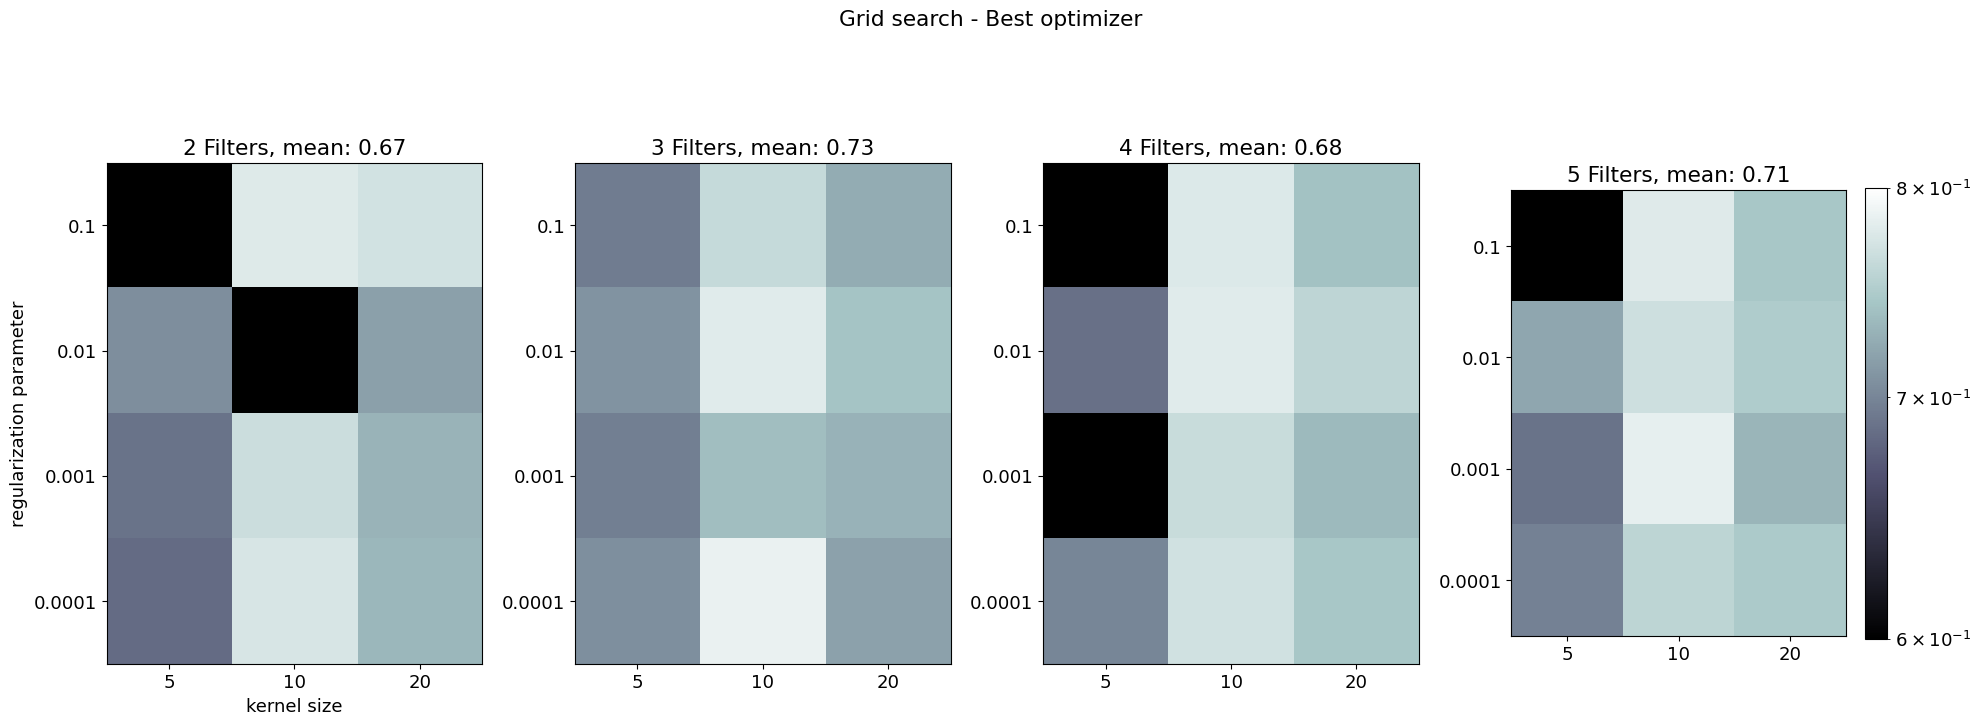

In [41]:
# visualizing grid search

fig, ax = plt.subplots(1,4, figsize = (20,8))
fig.suptitle('Grid search - Best optimizer')

ax[0].imshow(accL_array[:,:,0], cmap= 'bone', norm = LogNorm(vmin=0.6,vmax= 0.8))
ax[0].set_title(f'2 Filters, mean: {accL_array[:,:,0].mean():.2}')
ax[0].set_xlabel('kernel size')
ax[0].set_ylabel('regularization parameter')
ax[0].set_yticks(range(len(lamb)))
ax[0].set_yticklabels(lamb)
ax[0].set_xticks(range(len(KSs)))
ax[0].set_xticklabels(KSs)

ax[1].imshow(accL_array[:,:,1], cmap= 'bone', norm = LogNorm(vmin=0.6,vmax= 0.8))
ax[1].set_title(f'3 Filters, mean: {accL_array[:,:,1].mean():.2}')
ax[1].set_yticks(range(len(lamb)))
ax[1].set_yticklabels(lamb)
ax[1].set_xticks(range(len(KSs)))
ax[1].set_xticklabels(KSs)

ax[2].imshow(accL_array[:,:,2], cmap= 'bone', norm = LogNorm(vmin=0.6,vmax= 0.8))
ax[2].set_title(f'4 Filters, mean: {accL_array[:,:,2].mean():.2}')
ax[2].set_yticks(range(len(lamb)))
ax[2].set_yticklabels(lamb)
ax[2].set_xticks(range(len(KSs)))
ax[2].set_xticklabels(KSs)

im = ax[3].imshow(accL_array[:,:,3], cmap= 'bone', norm = LogNorm(vmin=0.6,vmax= 0.8))
ax[3].set_title(f'5 Filters, mean: {accL_array[:,:,3].mean():.2}')
ax[3].set_yticks(range(len(lamb)))
ax[3].set_yticklabels(lamb)
ax[3].set_xticks(range(len(KSs)))
ax[3].set_xticklabels(KSs)

fig.colorbar(im,fraction=0.06)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()

The heatmaps above show how the accuracy of the model varies as the hyperparameters change.
It can be observed that applying in the first convolutional layer 3 filters returns on average a better result, which can be interpreted as an optimization of the model in a 3-class output classification problem. Also, a kernel size of 10 gives the best validation accuracy almost for every number of filters.

## 4. Random search with `keras_tuner`

Finally we implemented the Keras built-in gridsearch function, namely *keras_tuner*. We decided to define as hyperparameters the number of filters, the kernel size, the number of convolutional layers after the first one, the activation functions in the convolutional layers (*relu, elu, leaky relu*), the gradient optimizer (*Adam, Adagrad, RMSprop, Nadam, Lion*) and some binary chosen dropout layers in the convolution segment.

In [43]:
import keras_tuner as kt

In [44]:
def builder_model(hp):

    model = Sequential()

    filterunits = hp.Int("filters", min_value=2, max_value=7, step=1)
    kernelunits = hp.Int("kernelsize", min_value=3, max_value=21, step=3)
    nlayers = hp.Choice("nlayers", [1, 2, 3, 4, 5])

    reg = hp.Choice('conv_regularizer', ['l1', 'l2', 'none'])

    if reg == 'none':
        kernel_regularizer = None
    elif reg == 'l1':
        kernel_regularizer = keras.regularizers.l1(0.01)
    elif reg == 'l2':
        kernel_regularizer = keras.regularizers.l2(0.01)

    model.add(Conv1D(
        filters=filterunits,
        kernel_size=kernelunits,
        kernel_regularizer=kernel_regularizer,
        activation=hp.Choice("activation", ["relu", "elu", "leaky_relu"]),
        input_shape=input_shape))

    for _ in range(1, nlayers):
        model.add(Conv1D(filters=filterunits, kernel_size=kernelunits, activation=hp.Choice("activation", ["relu", "elu", "leaky_relu"])))
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.2))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(n_class, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=hp.Choice("optimizer", ["adam", "adagrad", "RMSprop", "nadam", "lion"]),
                  metrics=['accuracy'])

    return model

In [45]:
tuner = kt.RandomSearch(hypermodel=builder_model,
                        objective='val_accuracy',
                        max_trials=50)

tuner.search(x_train,y_train,epochs=200,callbacks=[callback],batch_size=200,validation_data=(x_val, y_val), verbose=1, shuffle=True)

best_models = tuner.get_best_hyperparameters(num_trials=1)[0]

print()
print('Grid search results:')
print('filters:', best_models.get('filters'))
print('dropout:', best_models.get('dropout'))
print('activation:', best_models.get('activation'))
print('nlayers:', best_models.get('nlayers'))
print('regularization:', best_models.get('conv_regularizer'))
print('optimizer:', best_models.get('optimizer'))

Trial 50 Complete [00h 00m 37s]
val_accuracy: 0.5674999952316284

Best val_accuracy So Far: 0.7912499904632568
Total elapsed time: 00h 21m 22s

Grid search results:
filters: 6
dropout: True
activation: leaky_relu
nlayers: 2
regularization: l1
optimizer: adam


It can be seen that this renders slightly better results than the search grid we performed before, although almost comparable.
We can however observe that the best regularization obtained is the LASSO L1 regularization with *Adam* optimizer, the one that performed worse in the previous section.